# **引入的函式庫**

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

# **顯示圖像用函數**

In [12]:
def showImage(title, img): #顯示圖像function

      # 原圖像讀入時是BGR(OpenCV的讀取方式)，需轉換成RGB格式才是原先圖像的樣子
      ishow = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      # plt.imshow(欲顯示的圖像)
      plt.imshow(ishow)

      # 取消坐標軸
      plt.axis('off')

      # 顯示圖片的標題
      plt.title(title)

      # 用於將數據化成圖表的函式，但對顯示圖像來說上面足以，但若需要同時輸出多個圖像則需要添加
      plt.show()

# **Canny Alogrithm 前處理**

In [13]:
def Pre_Processing( Image ):

  # 處理前先將值域壓縮至 [0,1]
  Do_Image = np.float64(Image / 255)


  # Step 1 : 高斯模糊處理

  # Gassian 模糊的 sigma 取值為 圖像短邊長的 0.5%
  Sigma = 0.005 * min( Image.shape[0] , Image.shape[1] )

  # Kernel_Size 最小須為 sigma 的 6 倍，且為奇數
  Kernel_Size = int( np.round( 6 * Sigma ) )
  if Kernel_Size % 2 == 0:
    Kernel_Size += 1

  GB_Image = cv2.GaussianBlur( Do_Image , ( Kernel_Size , Kernel_Size ) , Sigma , Sigma )


  # Step 2 : Sobel提取邊界及角度資訊處理

  # Sobel 對 X、Y 的 kernel 如以下展示
  #
  # Sobel_X : -1 0 1   Sobel_Y : -1 -2  -1
  #       -2 0 2         0  0  0
  #       -1 0 1         1  2  1
  #
  # Sobel_X 檢測 垂直 的邊，定義角度 : -90 or 90
  # Sobel_Y 檢測 水平 的邊，定義角度 :  0 or 180
  Sobel_X  = cv2.Sobel( GB_Image , -1 , 1 , 0 , ksize=3 )
  Sobel_Y  = cv2.Sobel( GB_Image , -1 , 0 , 1 , ksize=3 )

  # Magnitude = ( Sobel_X^2 + Sobel_Y^2 )^0.5
  # Magnitude 會進行歸一化，除以該矩陣中最大的值
  Magnitude = np.sqrt(Sobel_X**2 + Sobel_Y**2)
  Magnitude = Magnitude / Magnitude.max()

  # Angle   = arctan( Sobel_X / Sobel_Y )
  # 角度值域 : -pi/2 ~ pi/2 
  Angle   = np.arctan(Sobel_X/(Sobel_Y+1e-8))

  # 回傳 Magnitude , Angle
  # 前者為真實邊界的前處理結果，後者為判斷依據
  return Magnitude , Angle

# **Nonmaxima Suppression**

In [14]:
def NMS( Magnitude , Angle , TH , TL ):

  # 定義 
  pi = 3.1415926 
  # 建立 Gn、GnH、GnL
  Gn = np.zeros( ( Magnitude.shape[0] , Magnitude.shape[1] ) , dtype = np.float32 )
  GnH = np.zeros( ( Magnitude.shape[0] , Magnitude.shape[1] ) , dtype = np.float32 )
  GnL = np.zeros( ( Magnitude.shape[0] , Magnitude.shape[1] ) , dtype = np.float32 )

  # cv2.copyMakeBorder( 欲讀取之圖像矩陣, 上邊增行,下邊增行,左邊增行,右邊增行 , padding方案 )
  # Padding方案詳見此網站：https://www.twblogs.net/a/5d304a58bd9eee51fbf80c77
  # 由於判斷需要 3*3 的 kernel，故需一層 padding
  M_Padding = cv2.copyMakeBorder( Magnitude, 1,1,1,1, cv2.BORDER_REPLICATE )
  A_Padding = cv2.copyMakeBorder( Angle  , 1,1,1,1, cv2.BORDER_REPLICATE )

  # 進行操作的範圍是 Padding 後，外圍 1 個 pixel 寬度以內的部分
  for i in range( 1  , M_Padding.shape[0]-1 ):
    for j in range( 1  , M_Padding.shape[1]-1 ):

      # 邊界為 "水平" 樣式 ( 角度範圍 : -22.5度 ~ 22.5度 )
      # 比較 pixel : 正上、正下
      if abs( A_Padding[i,j] ) <= (pi/8):
        v1 = M_Padding[i-1,j]
        v2 = M_Padding[i+1,j]

      # 邊界為 "垂直" 樣式 ( 角度範圍 : 絕對值 >= 67.5度 )
      # 比較 pixel : 正左、正右
      elif abs( A_Padding[i,j] ) >= (3*pi/8):
        v1 = M_Padding[i,j-1]
        v2 = M_Padding[i,j+1]

      # 邊界為 "-45度斜直線 \ " 樣式 ( 角度範圍 : -67.5度 ~ -22.5度)
      # 比較 pixel : 左下、右上
      elif A_Padding[i,j] < (-pi/8) and A_Padding[i,j] > (-3*pi/8):
        v1 = M_Padding[i-1,j+1]
        v2 = M_Padding[i+1,j-1]

      # 邊界為 "45度斜直線 / " 樣式 ( 角度範圍 : 22.5度 ~ 67.5度)
      # 比較 pixel : 左上、右下
      elif A_Padding[i,j] > (pi/8) and A_Padding[i,j] < (3*pi/8):
        v1 = M_Padding[i-1,j-1]
        v2 = M_Padding[i+1,j+1]

      # 若 Kernal 正中央的值非最大值，則表示不是邊界
      # 由於 M_Padding 中央的範圍正是 Gn 需要的部分，因此位置上須 -1
      # 也就是，現在 for 迴圈的取值範圍在 [ 1 , Gn.shape[0] ]
      # 要把值灌進範圍是 [ 0 , Gn.shape[0]-1 ] 的 Gn，就要把位置 -1
      # 下面的 GnH、GnL 同理
      if ( v1 <= M_Padding[i,j] ) and ( v2 <= M_Padding[i,j] ):
        Gn[i-1,j-1] = M_Padding[i,j]

      # 產GnH，大於 TH 的值表示必為邊界
      if Gn[i-1,j-1] >= TH :
        GnH[i-1,j-1] = Gn[i-1,j-1]
      # 產GnL，介於 TH 和 TL 之間表示可能為邊界
      elif Gn[i-1,j-1] >= TL :
        GnL[i-1,j-1] = Gn[i-1,j-1]

  return GnH , GnL

# **Hysteresis Thresholding**

In [15]:
def Hysteresis_Thresholding( GnH , GnL ):

  # 建立最後結果圖
  Edge = np.zeros( ( GnH.shape[0] , GnH.shape[1] ) , dtype = np.uint8 )

  # Padding 道理同 NMS 的 Magnitude
  H_Padding = cv2.copyMakeBorder( GnH , 1,1,1,1, cv2.BORDER_REPLICATE )
  L_Padding = cv2.copyMakeBorder( GnL , 1,1,1,1, cv2.BORDER_REPLICATE )

  for i in range( 1  , H_Padding.shape[0]-1 ):
    for j in range( 1  , H_Padding.shape[1]-1 ):

      # 將必定是邊界的部分先化為 255
      if H_Padding[i,j] != 0 :
        Edge[i-1,j-1] = 255

        # 若必定邊界的鄰居 存在 可能 是邊界的元素。則也化為 255
        for k in range(-1,2):
          for l in range(-1,2):
            if L_Padding[i+k,j+l] != 0:
              Edge[i-1+k,j-1+l] = 255

  return Edge

# **測試**

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29392 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33287 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24555 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27138 missing from current font.
  font.set_

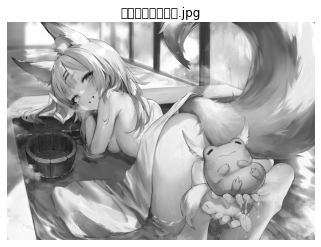

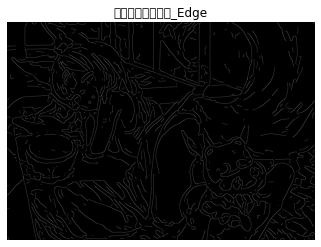

In [16]:
picture_name = "狐與呱的快樂溫泉"
picture_form = "jpg"

# cv2.imread( 欲讀取的圖像名稱 , 讀取方案 )
# 讀取方案為: 0--灰階 、1--彩色(BGR)
# 讀取的格式為numpy，大小為[ 圖片高 , 圖片寬 , 3(彩色) or 1(灰階) ]
IMG = cv2.imread( picture_name + "." + picture_form , 0)

# 自定義的函數，詳見第二區塊
showImage( picture_name + "." + picture_form , IMG)

M,A = Pre_Processing( IMG )

# TH , TL 僅接受 [0,1] 範圍
H,L = NMS( M , A , 0.1 , 0.04 )

E = Hysteresis_Thresholding( H , L )

IMG_output = Image.fromarray(E)
IMG_output.save( picture_name + "_Edge" + ".tif",dpi=(200.0,200.0))
showImage( picture_name + "_Edge"  , E)